# This Notebook explores the SCAR GeoMAP dataset released in 2019
## Cox S.C., Smith Lyttle B. and the GeoMAP team (2019). Lower Hutt, New Zealand. GNS Science. Release v.201907.
### [Data Available Here](https://data.gns.cri.nz/ata_geomap/index.html?content=/mapservice/Content/antarctica/www/index.html)
### Notebook by Sam Elkind

Initially, I'll look at the data in terms of polygon counts. This section will be focused on examining the data schema and frequency of values occurring within specific fields. This investigation will focus on finding inconsistencies in the data attribution, but also could stimulate some discussion regarding relationships between columns.

Next, I'll look at the data in terms of polygon area and data attribution. How much surface water has been mapped? How much till has been mapped? How much outcropping rock is of Jurassic age?

### Configure packages, paths, and load data

In [1]:
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import pprint as pp
from tabulate import tabulate

In [2]:
def plot_value_counts(field_name, values_to_plot, counts, counts_norm):
    fig, ax = plt.subplots(2, 1, figsize=(30,15))
    fig.tight_layout(pad=2.0)
    fig.subplots_adjust(top=.94)
    fig.suptitle(f"Frequency of {field_name} values", size=18)

    ax[0].set_title(field_name)
    ax[1].set_title(f"{field_name} normalized")
    for i, v in enumerate(counts[:values_to_plot]):
        ax[0].text(i - .5, v, str(v), color='black', fontweight='bold')
    for i, v in enumerate(counts_norm[:values_to_plot]):
        ax[1].text(i - .5, v, f"{str(v * 100)[:3]}%", color='black', fontweight='bold')
    ax[0].bar(counts.index[:values_to_plot], counts[:values_to_plot])
    ax[1].bar(counts_norm.index[:values_to_plot], counts_norm[:values_to_plot])

In [3]:
geol_path = f"{os.getcwd()}/data/ATA_SCAR_GeoMAP_geology.gdb"
print(geol_path)

/home/gt/geomap/data/ATA_SCAR_GeoMAP_geology.gdb


In [4]:
data = gpd.read_file(geol_path)

## What can we learn just from looking at the number of unique values for each attribute?

In [5]:
nunique_cols = pd.DataFrame(data.nunique())
display(nunique_cols)

,0
SOURCECODE,801
MAPSYMBOL,173
PLOTSYMBOL,183
NAME,666
DESCR,757
POLYGTYPE,3
MBREQUIV,19
FMNEQUIV,246
SBGRPEQUIV,1
GRPEQUIV,59


### Discussion of unique column values
#### A lot of answers to the questions posed here will likely come down to what each column is supposed to represent.
- [x] 95,128 total polys
-  [x] 801 original source units have been compressed into 183 units based on the Chronostratigraphic Legend
- [x]  My understanding of MAPSYMBOL AND PLOTSYMBOL was that they were pretty much equivalent. Is there a good reason for the fact that they have a different number of unique values?
- [x]  Interestingly, there are more SOURCECODE values than NAMEs. It could be important to look into records that have the same NAME, but distinct SOURCECODEs.
- [x]  I would also imagine that each named unit should have a single description. Because the DESC field is a longer string, I suspect that there may be formatting inconsistencies.
- [ ] based upon the previous bullet point and name_descr_investigation.ipynb it is more likely that descr and sourcecode are more or less deterministic. I'll add a notebook looking into their relationship
- [ ]  POLYGTYPE will be a very good column to group by when doing descriptive statistics.
- [ ]  SUBGRPEQUIV has only one value, is it worth including in the schema?
- [ ]  There are 12 STRATRANKS. Several values have their own column, should there be a column for each of them? Should the values be normalized to fit within existing EQUIV columns?
- [ ]  6 TYPENAME values but only 5 TYPE_URIs.
- [ ]  LITHCODE and REPLITH_URI may need the same number of values, although those columns may not need to be deterministically related
- [ ]  LITHOLOGY may need some formatting to reduce the number of unique values.
- [ ]  CONFIDENCE has 162 unique values. It may be valuable to normalize the values in this field into broader categories, resulting in fewer values
- [ ]  152 Sources, It would be interesting to look at citation numbers of each source and possibly rank sources for each DATASET
- [ ]  SYMBOL seems to be an unused column
- [ ]  How formal are the Dataset areas? Can we draw well-defined footprints on a continent scale map for them?
- [ ]  why do some geometries not have Shape_Lengths and areas. Do these need to be recalculated to be included in the next release?


### Let's look at the 10 most frequently occurring values for several of the columns

In [6]:
value_count_cols = ["SOURCECODE", "PLOTSYMBOL", "POLYGTYPE", "MBREQUIV", "FMNEQUIV", "GRPEQUIV", "TERREQUIV", "STRATRANK", "TYPENAME", "GEOLHIST", "REPAGE_URI", "AGECODE", "LITHCODE", "REPLITH_URI", "OBSMETHOD", "CONFIDENCE", "SOURCE", "DATASET", "REGION",]
print(len(value_count_cols))
value_counts = [data[i].value_counts(ascending=False) for i in value_count_cols]

19


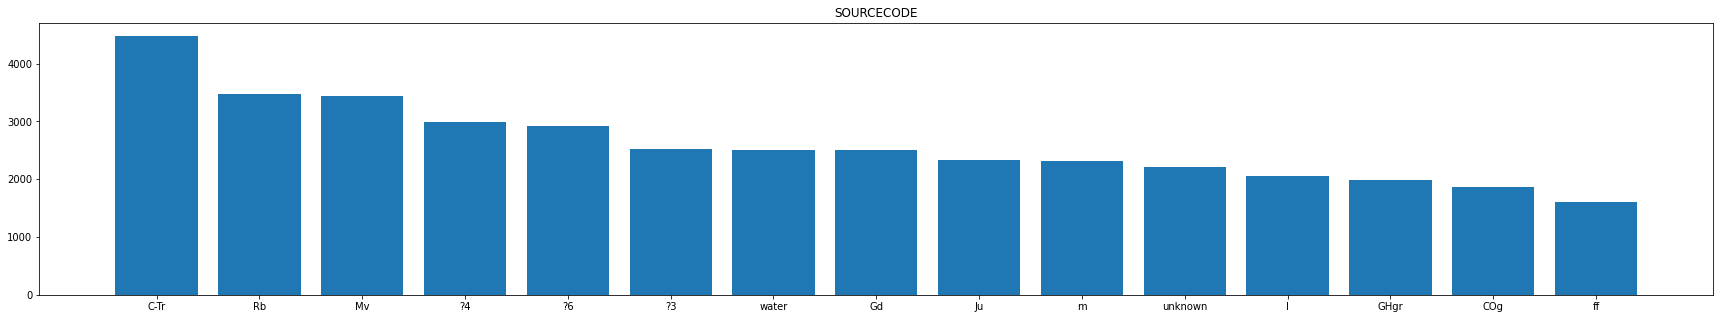

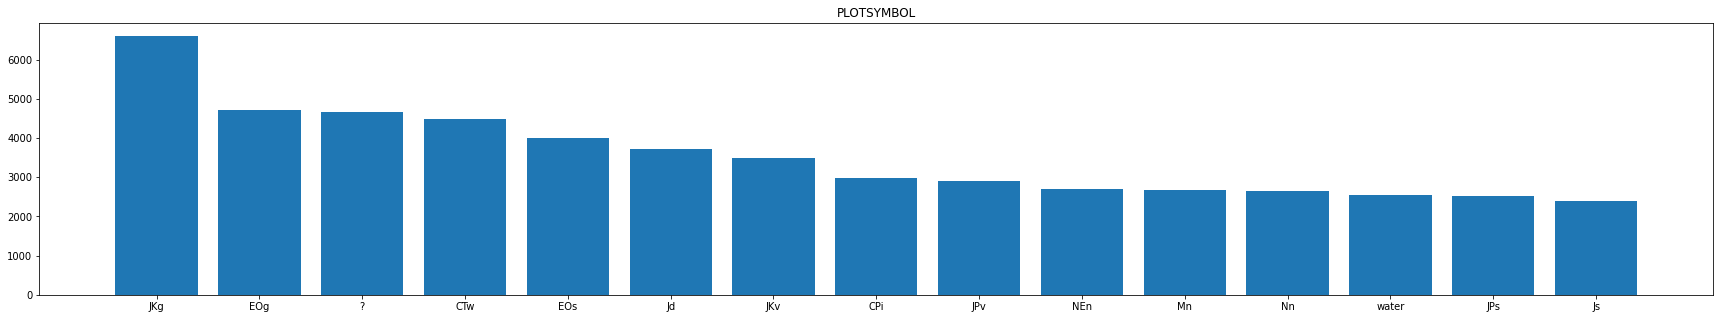

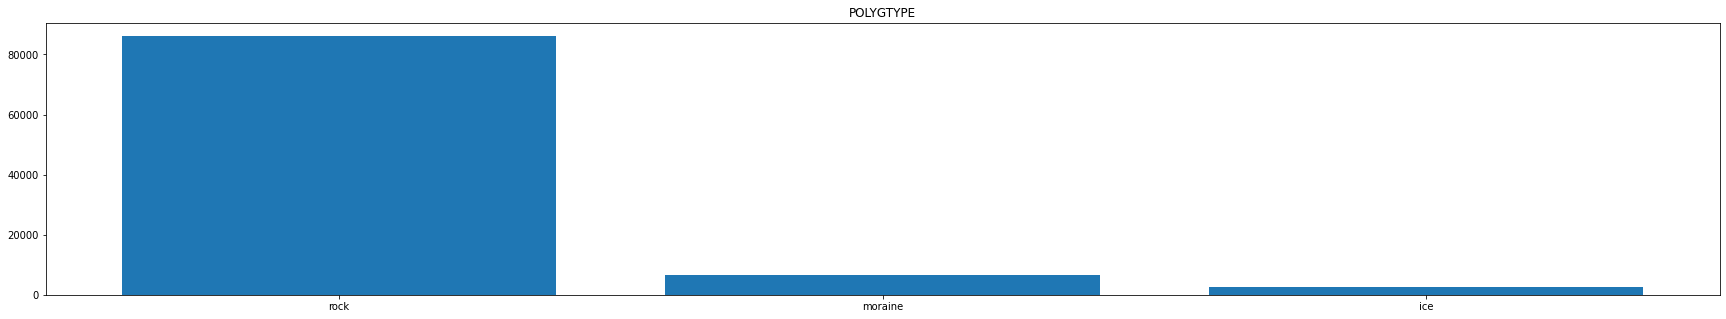

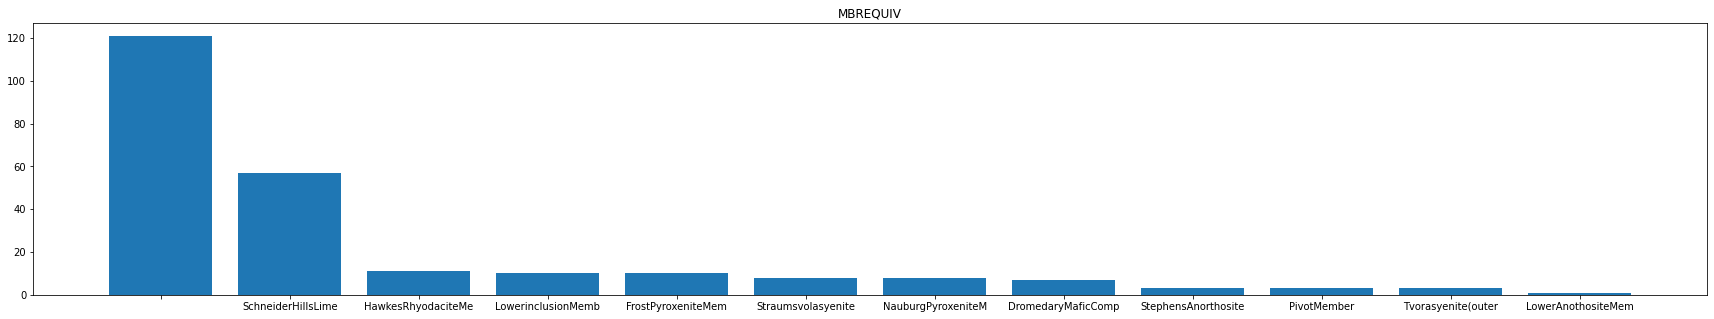

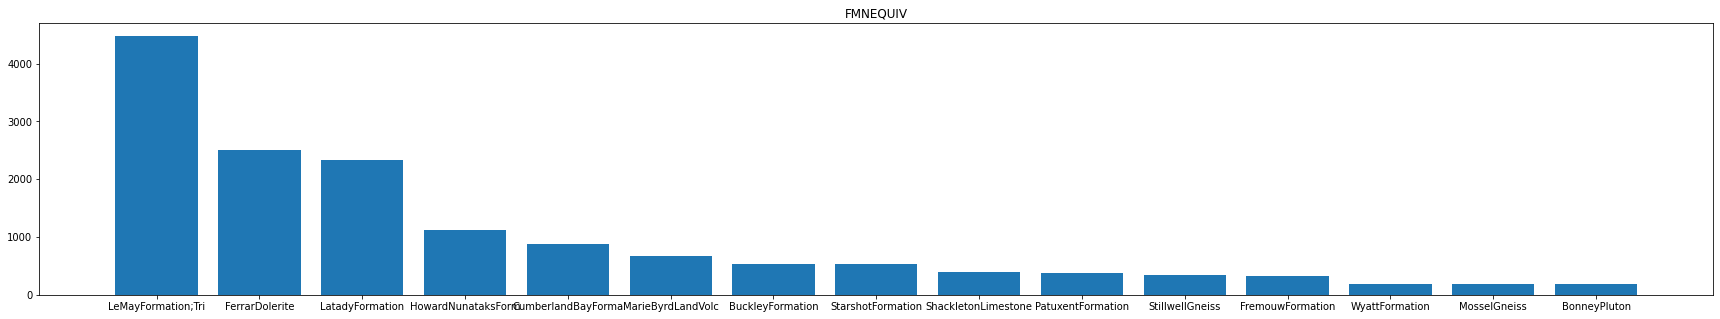

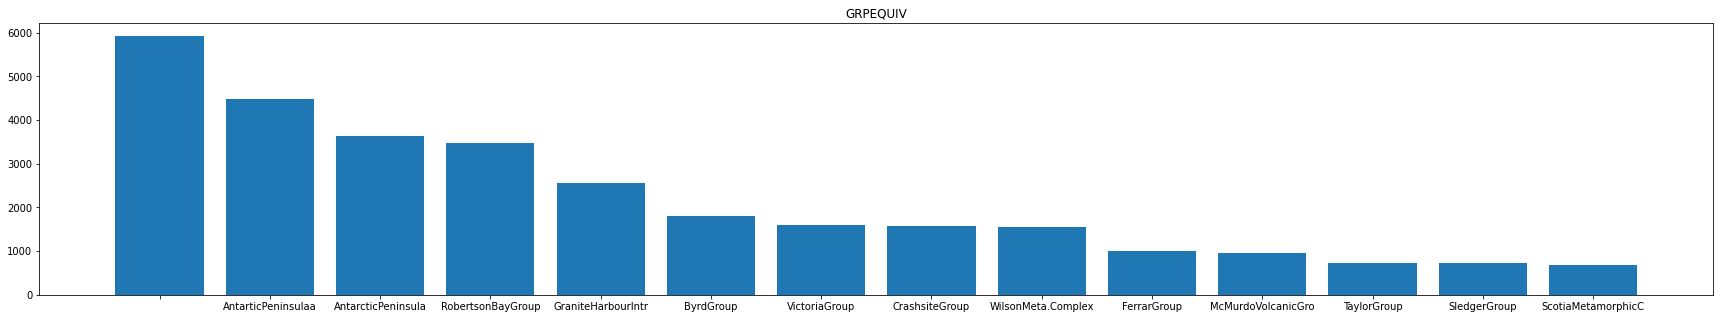

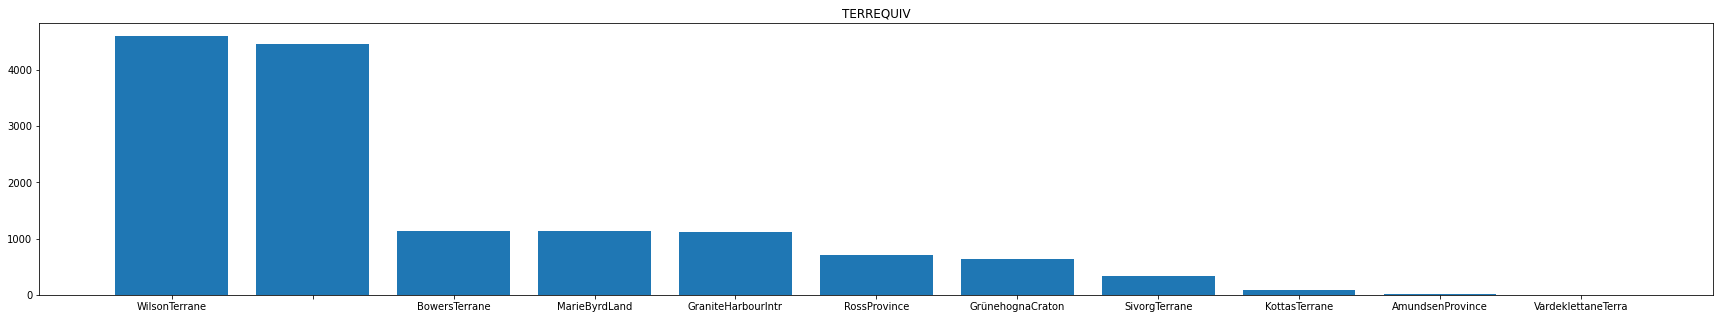

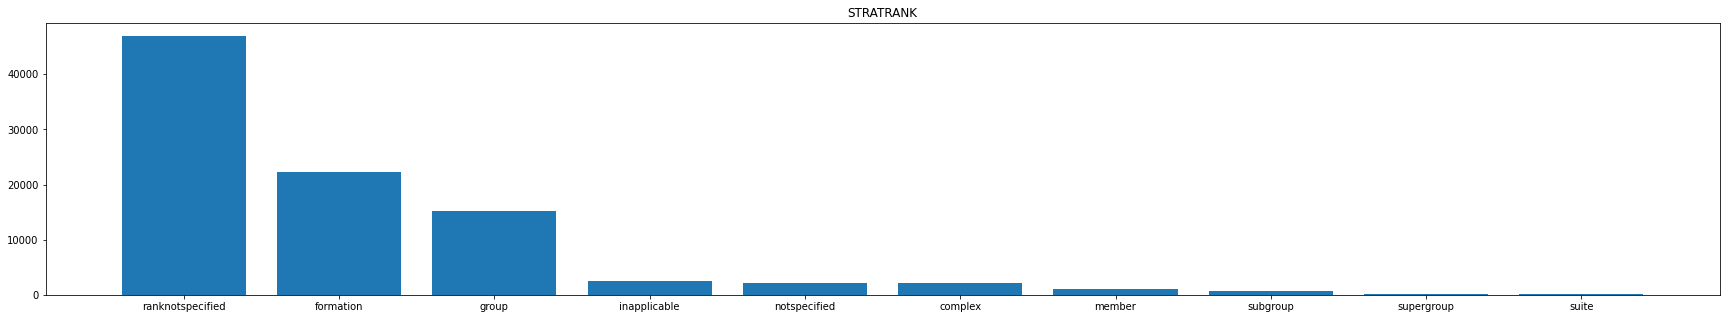

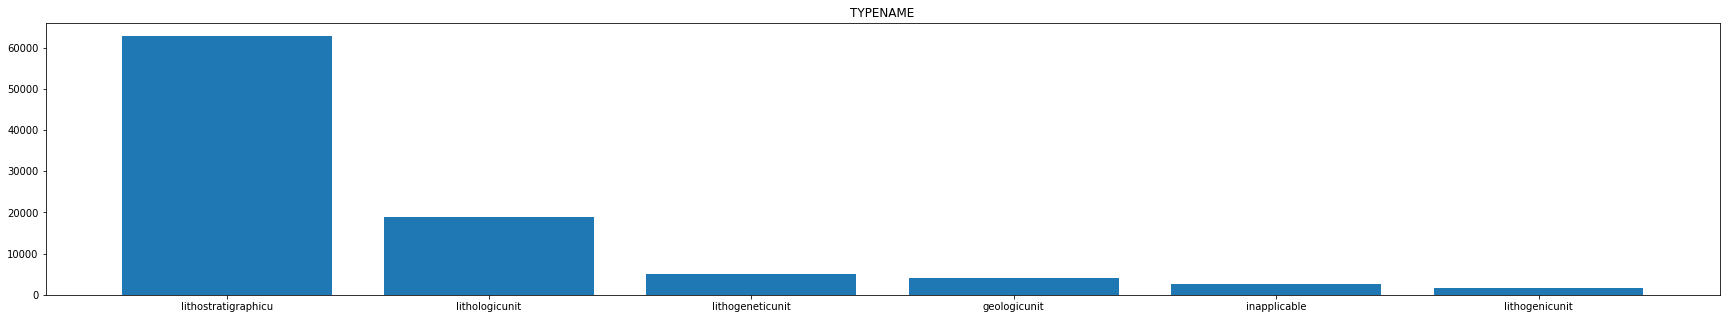

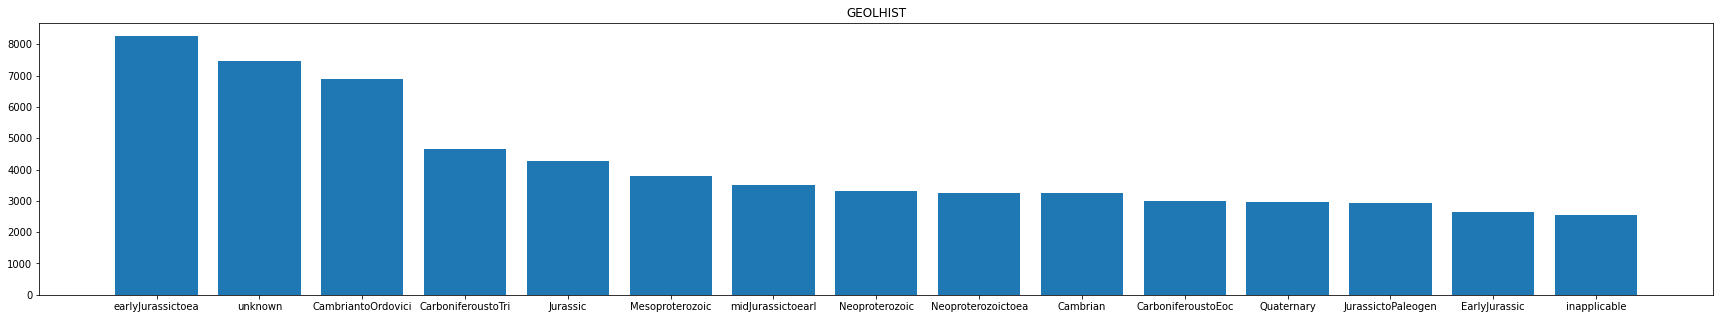

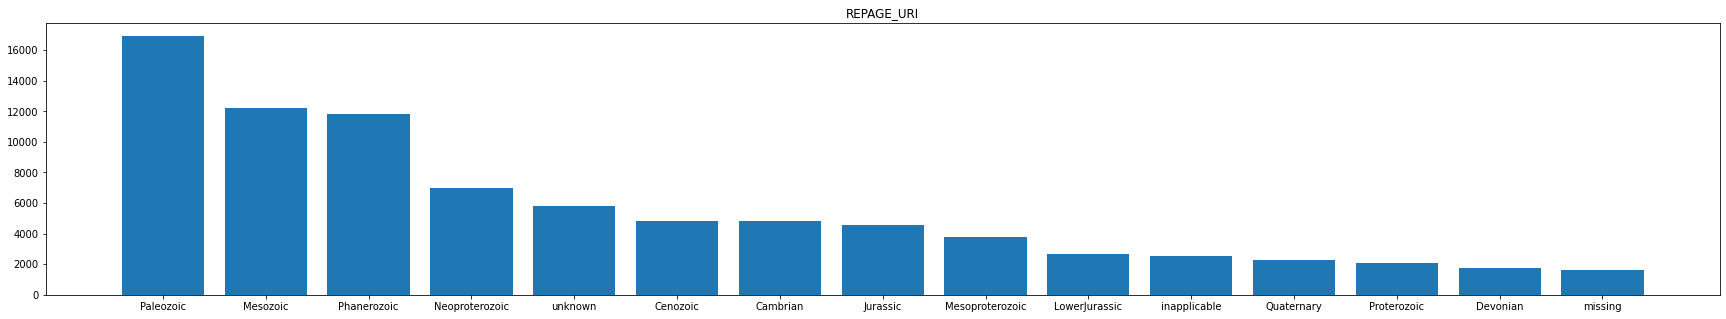

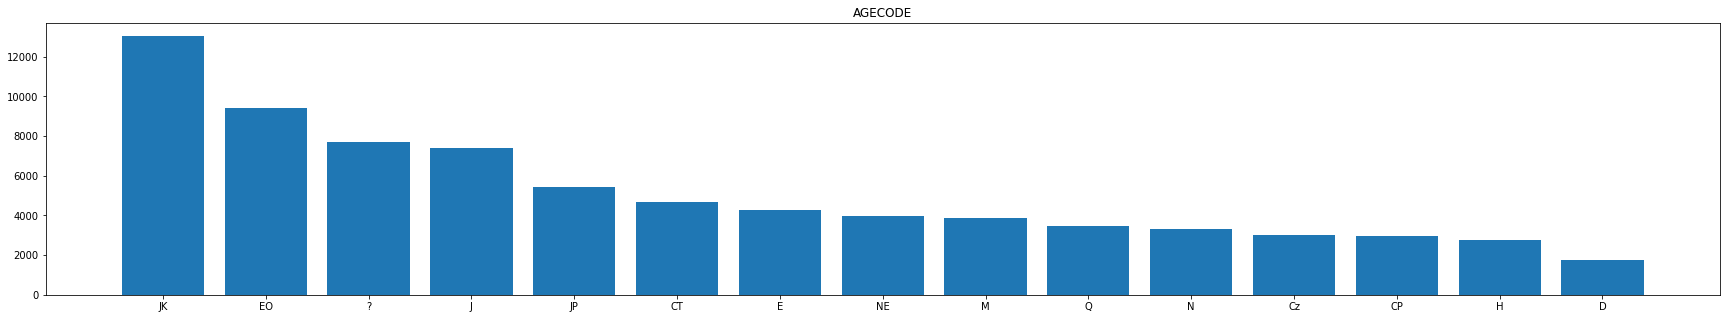

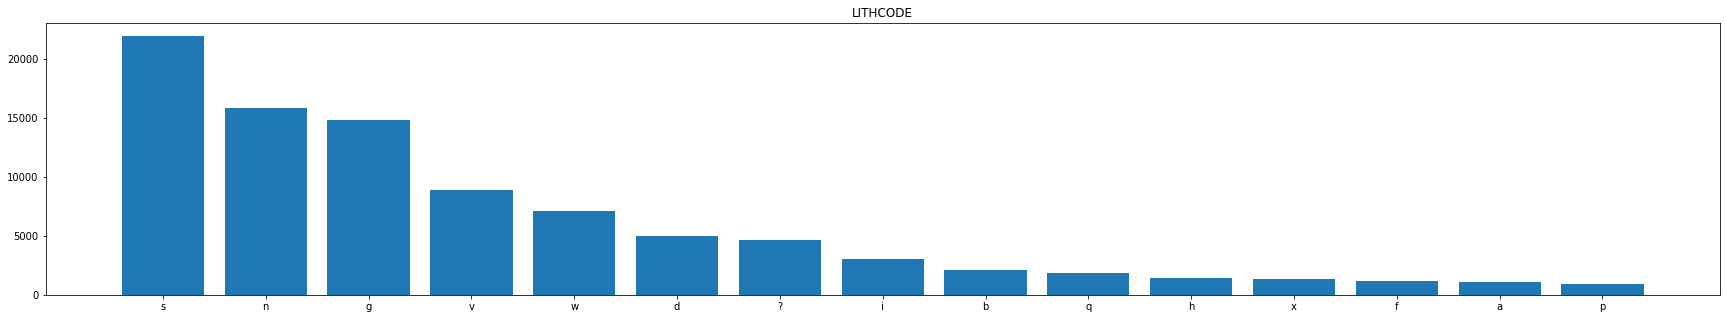

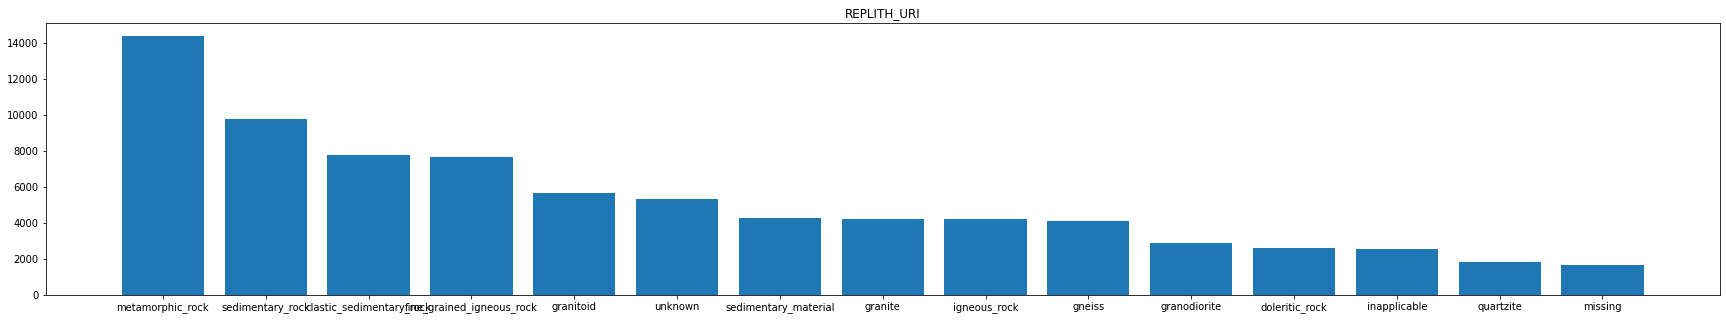

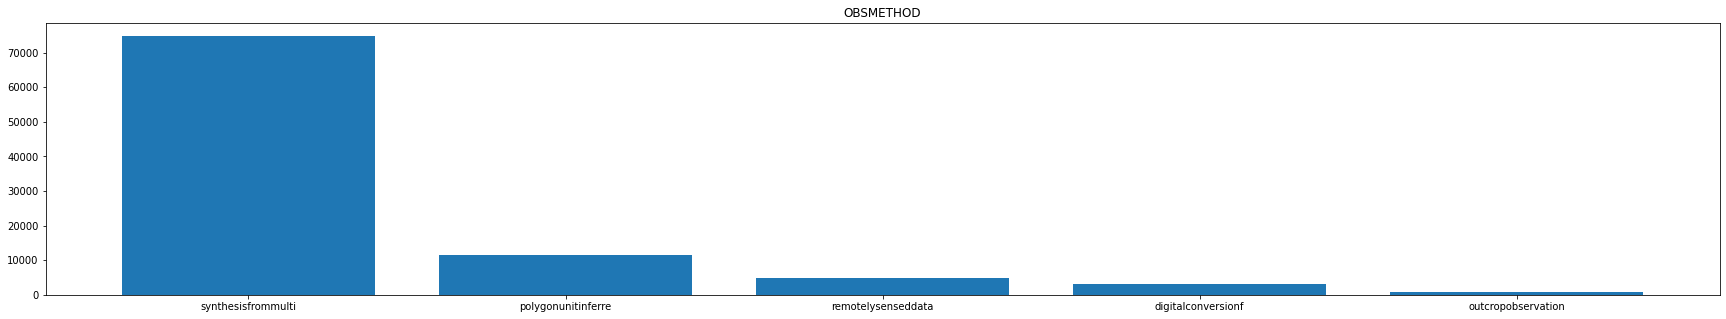

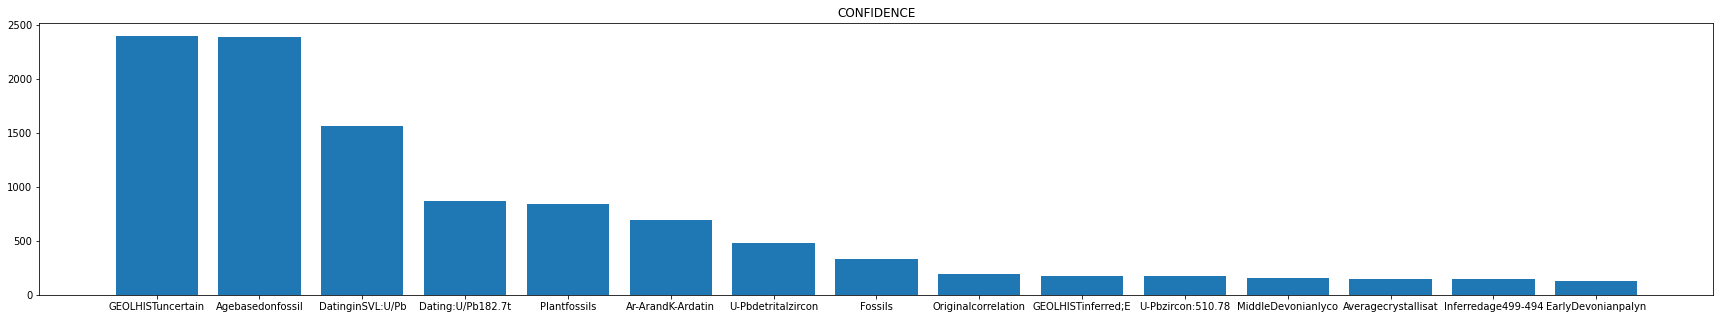

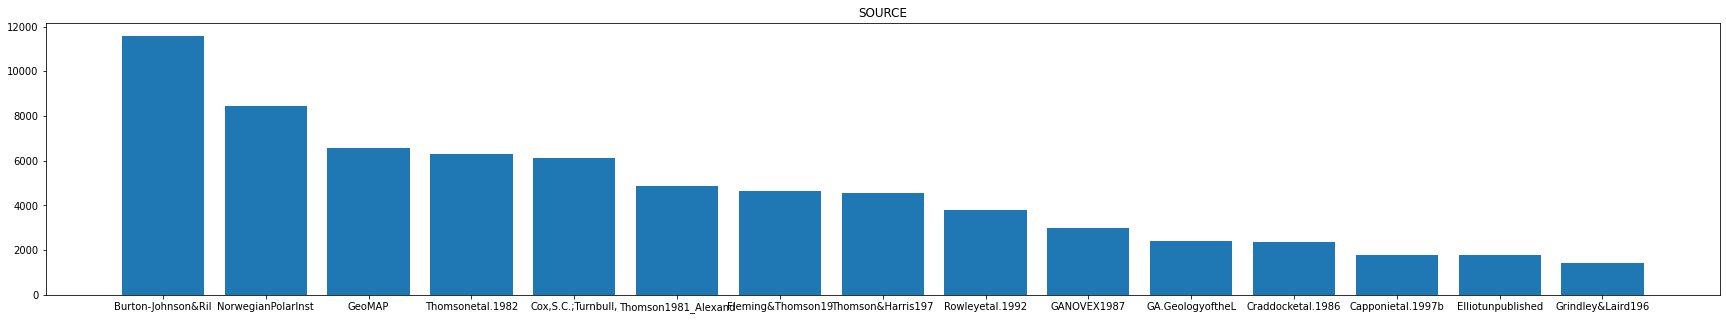

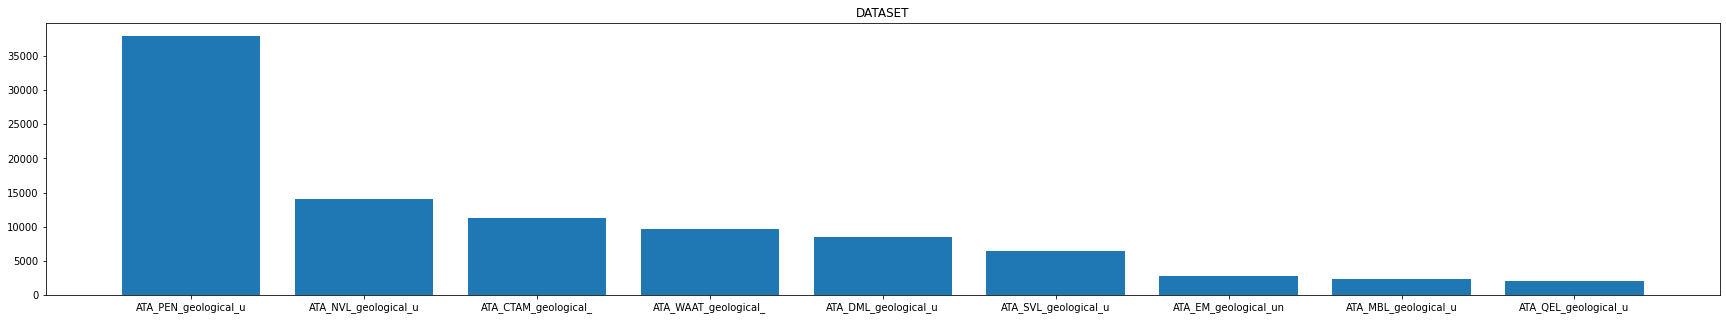

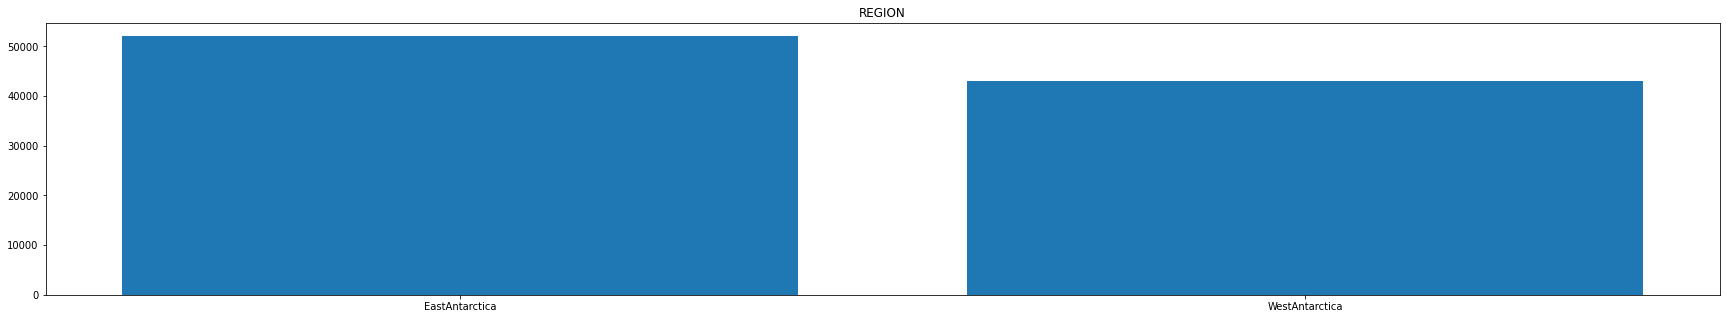

In [7]:
max_bars = 15
label_chars = 20
for i in range(len(value_counts)):
    fig, ax = plt.subplots(1,1, figsize=(30, 5))
        
    ax.set_title(value_count_cols[i])
    counts = len(value_counts[i])
    if counts >= max_bars:
        counts = max_bars 
    try:
        if value_count_cols[i][-4:] == "_URI":
            labels = [j[j.rindex("/") + 1:].replace(" ", "") for j in value_counts[i].index[:counts]]
        else:
            labels = [j[:label_chars].replace(" ", "") for j in value_counts[i].index[:counts]]
        ax.bar(labels, value_counts[i][:counts])
    except KeyError:
        print(counts, value_count_cols[i])
    fig.show()